# Задание 5.

Загрузите [данные по изменению температуры поверхности земли](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data). Для этого может понадобится зарегистрироваться на [Kaggle](https://kaggle.com). Затем нужно будет работать с данными, которые содержатся в файле **GlobalLandTemperaturesByMajorCity.csv**

**NB** Все подсчеты необходимо делать с помощью `PySpark`, без применения `pandas api`. Можно использоать `SQL`.

In [22]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, expr, desc, avg, when, abs, lag, lead
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.ml.linalg import DenseVector

%matplotlib inline
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("PySpark") \
    .getOrCreate()

with zipfile.ZipFile("archive.zip") as z:
    with z.open("GlobalLandTemperaturesByMajorCity.csv") as f:
        pandas_df = pd.read_csv(f)
        df = spark.createDataFrame(pandas_df)

df.show(10)

+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|   City|      Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|1849-01-01|            26.704|                        1.435|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-02-01|            27.434|                        1.362|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-03-01|            28.101|                        1.612|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-04-01|             26.14|           1.3869999999999998|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-05-01|            25.427|                          1.2|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-06-01|            24.844|                        1.402|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-07-01|24.058000000000003|                        1.254|Abidjan|Côte

# Задание 3.1 (1 балл)

В последующих заданиях будут учитываться данные начиная с 01.01.1950. Для этого создайте новый `DataFrame`, в котором удалены все строки до 01.01.1950. Используйте созданный DataFrame в последующих заданиях.  

In [23]:
new_df = df.filter(col('dt') >= "1950-01-01")
new_df.show(10)

+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|   City|      Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|1950-01-01|26.773000000000003|                        0.239|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-02-01|            27.527|                        0.348|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-03-01|            28.344|                        0.431|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-04-01|             27.83|                        0.467|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-05-01|            26.896|                        0.248|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-06-01|            25.454|                        0.209|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-07-01|            24.878|                        0.403|Abidjan|Côte

# Задание 3.2 (2 балла)

Постройте график среднегодовых температур в городе Торонто.

+----+------------------+
|Year|    AvgTemperature|
+----+------------------+
|1950| 5.639583333333335|
|1951| 6.259083333333334|
|1952| 7.013416666666667|
|1953|7.5062500000000005|
|1954| 6.243083333333332|
|1955| 6.974750000000001|
|1956| 5.745750000000001|
|1957| 6.424916666666667|
|1958| 5.624333333333333|
|1959| 6.403750000000001|
+----+------------------+
only showing top 10 rows



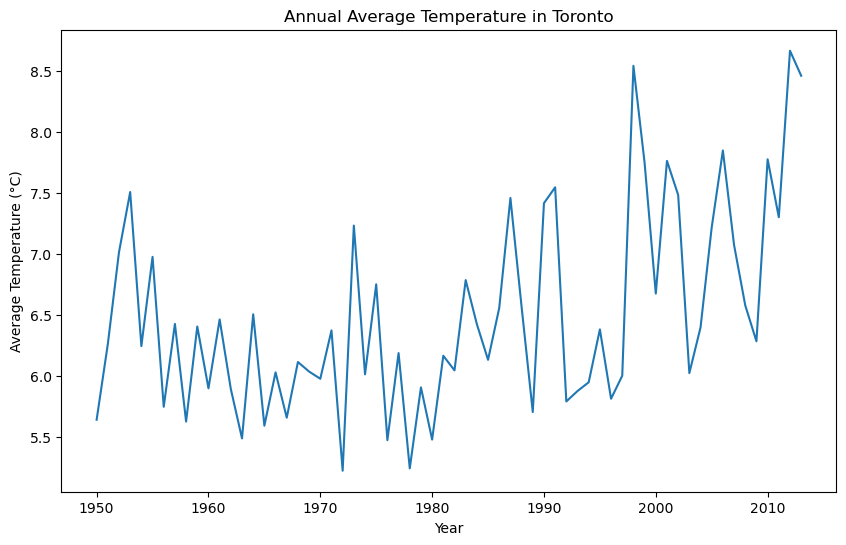

In [24]:
toronto_df = new_df.filter(new_df.City == "Toronto")
toronto_df = toronto_df.withColumn("Year", F.year(F.col("dt")))
avg_temp_df = toronto_df.groupBy("Year").agg(F.avg("AverageTemperature").alias("AvgTemperature"))
sorted_df = avg_temp_df.orderBy("Year")
sorted_df.show(10)

years = sorted_df.select("Year").rdd.flatMap(lambda x: x).collect()
avg_temps = sorted_df.select("AvgTemperature").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
plt.plot(years, avg_temps)
plt.xlabel("Year")
plt.ylabel("Average Temperature (°C)")
plt.title("Annual Average Temperature in Toronto")
plt.show()

# Задание 3.3 (2 балла)

Найдите город, для которого выборочная дисперсия температур на приведенных данных максимальна. 

In [25]:
cleaned_df = new_df.na.drop(subset=["AverageTemperature"])
city_temp_var = cleaned_df.groupBy('City').agg(F.var_samp('AverageTemperature').alias('VarTemperature'))
city_temp_var_sorted = city_temp_var.sort('VarTemperature', ascending=False)
city_temp_var_sorted.show(1)

+------+----------------+
|  City|  VarTemperature|
+------+----------------+
|Harbin|218.898615951821|
+------+----------------+
only showing top 1 row



# Задание 3.4 (4 балла)

На одной оси постройте графики, отображающие:
1. Зависимость выборочной дисперсии температур от широты города (Latitude).
2. Зависимость средней температуры в январе 1975 года от широты города (Latitude).
3. Зависимость средней температуры в июле 1975 года от широты города (Latitude).

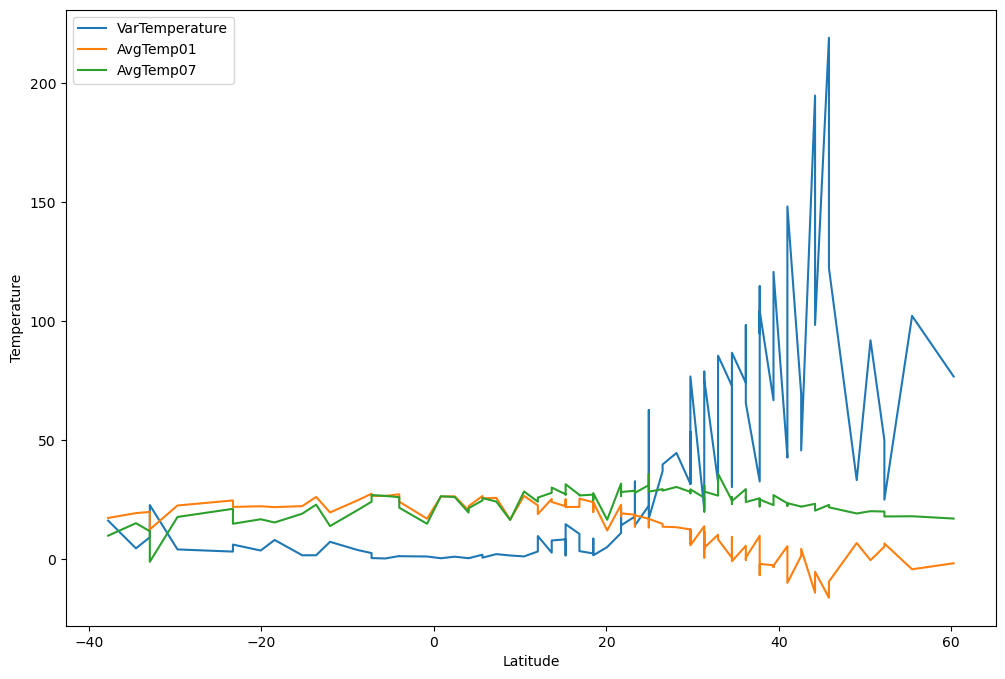

In [26]:
cleaned_df = cleaned_df.withColumn(
    "LatitudeValue",
    expr("CASE WHEN Latitude LIKE '%N' THEN substring(Latitude, 1, length(Latitude)-1) WHEN Latitude LIKE '%S' THEN -substring(Latitude, 1, length(Latitude)-1) END").cast("double")
)

# 1.Зависимость выборочной дисперсии температур от широты города (Latitude)
city_var = cleaned_df.groupBy('City', 'LatitudeValue').agg(F.var_samp('AverageTemperature').alias('VarTemperature'))

# 2.Зависимость средней температуры в январе 1975 года от широты города (Latitude)
df_1975_01 = cleaned_df.filter((year(cleaned_df['dt']) == 1975) & (month(cleaned_df['dt']) == 1))
city_01 = df_1975_01.groupBy('City', 'LatitudeValue').agg(F.avg('AverageTemperature').alias('AvgTemp01'))

# 3.Зависимость средней температуры в июле 1975 года от широты города (Latitude)
df_1975_07 = cleaned_df.filter((year(cleaned_df['dt']) == 1975) & (month(cleaned_df['dt']) == 7))
city_07 = df_1975_07.groupBy('City', 'LatitudeValue').agg(F.avg('AverageTemperature').alias('AvgTemp07'))

city_var = city_var.rdd.sortBy(lambda x: x['LatitudeValue']).collect()
city_01 = city_01.rdd.sortBy(lambda x: x['LatitudeValue']).collect()
city_07 = city_07.rdd.sortBy(lambda x: x['LatitudeValue']).collect()

latitude_var_temp = [row['LatitudeValue'] for row in city_var]
var_temperature = [row['VarTemperature'] for row in city_var]

latitude_avg_temp_01 = [row['LatitudeValue'] for row in city_01]
avg_temp_01 = [row['AvgTemp01'] for row in city_01]

latitude_avg_temp_07 = [row['LatitudeValue'] for row in city_07]
avg_temp_07 = [row['AvgTemp07'] for row in city_07]

plt.figure(figsize=(12, 8))
plt.plot(latitude_var_temp, var_temperature, label='VarTemperature')
plt.plot(latitude_avg_temp_01, avg_temp_01, label='AvgTemp01')
plt.plot(latitude_avg_temp_07, avg_temp_07, label='AvgTemp07')
plt.xlabel('Latitude')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Задание 3.5 (6 баллов)

Посчитайте данные по среднегодовой температуре в Санкт-Петербурге. Определите года, в которых средняя температура была выше, чем в предыдущем  и последующем году. Постройте график среднегодовой температуры и обозначьте на нём найденные года (произвольным образом). 

Постройте модель линейной регрессии (можно использовать [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)): $\mathbb{год} \rightarrow \mathbb{средняя\_температура}$. Отобразите прямую на предыдущем графике. 

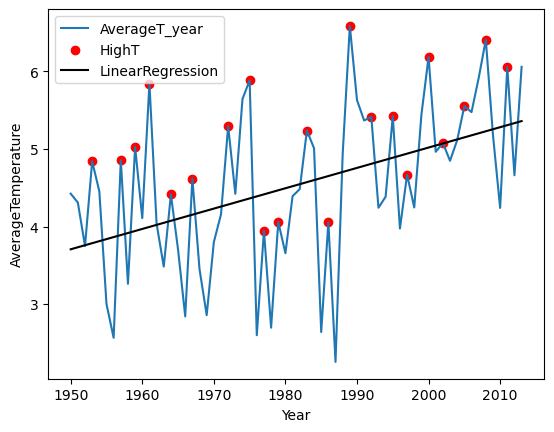

In [27]:
from pyspark.ml.regression import LinearRegression

df_SPB = cleaned_df.filter(cleaned_df.City == 'Saint Petersburg')

df_SPB = df_SPB.withColumn("Year", F.year(F.col("dt")))
SPB_mean = df_SPB.groupBy("Year").agg(F.avg("AverageTemperature").alias("AvgTemperature"))
SPB_mean = SPB_mean.orderBy("Year")

windowSpec = Window.orderBy('Year')
SPB_mean = SPB_mean.withColumn('Previous_Year', lag(col('AvgTemperature')).over(windowSpec))
SPB_mean = SPB_mean.withColumn('Next_Year', lead(col('AvgTemperature')).over(windowSpec))

high = SPB_mean.filter((SPB_mean['AvgTemperature'] > SPB_mean['Previous_Year']) &
                       (SPB_mean['AvgTemperature'] > SPB_mean['Next_Year']))

SPB_mean_rdd = SPB_mean.rdd
high_rdd = high.rdd

SPB_mean_list = SPB_mean_rdd.collect()
high_list = high_rdd.collect()

year_list = [row['Year'] for row in SPB_mean_list]
avg_temp_list = [row['AvgTemperature'] for row in SPB_mean_list]
high_year_list = [row['Year'] for row in high_list]
high_temp_list = [row['AvgTemperature'] for row in high_list]

plt.plot(year_list, avg_temp_list, label='AverageT_year')
plt.xlabel('Year')
plt.ylabel('AverageTemperature')
plt.scatter(high_year_list, high_temp_list, c='r', label='HighT')


# LinearRegression
regression_data = SPB_mean_rdd.map(lambda row: (DenseVector([row['Year']]), row['AvgTemperature']))
regression_df = spark.createDataFrame(regression_data, ['features', 'label'])

lr = LinearRegression(featuresCol='features', labelCol='label')
model = lr.fit(regression_df)
predictions_df = model.transform(regression_df)
predictions_list = predictions_df.select('features', 'prediction').rdd.collect()

predictions_year_list = [row['features'][0] for row in predictions_list]
predictions_temp_list = [row['prediction'] for row in predictions_list]

plt.plot(predictions_year_list, predictions_temp_list, color='black', label='LinearRegression')
plt.legend()
plt.show()

# Задание 3.6 (4 балла)

Найдите города, для которых: 
1. Разница между максимальным и минимальным значением среднегодовой температуры в выборке максимальна.
2. Самая большая средняя разница между средней температурой января и средней температурой июля.
3. Наибольшее среднее количество месяцев с отрицательной температурой в году.

In [28]:
# 1.Разница между максимальным и минимальным значением среднегодовой температуры в выборке максимальна
df_city_year = cleaned_df.groupBy('City', year('dt')).mean()
windowSpec = Window.partitionBy('City')
max_diff = F.max('avg(AverageTemperature)').over(windowSpec) - F.min('avg(AverageTemperature)').over(windowSpec)
df_city_max_diff = df_city_year.select('City', max_diff.alias('max_diff')).distinct()
max_diff_city = df_city_max_diff.orderBy(F.desc('max_diff')).first()['City']
print(max_diff_city)

# 2.Самая большая средняя разница между средней температурой января и средней температурой июля
df_city = cleaned_df.groupby('City')
diff17 = df_city.agg(
    (avg(when(month(col('dt')) == 1, col('AverageTemperature')))).alias('avg_temp_1'),
    (avg(when(month(col('dt')) == 7, col('AverageTemperature')))).alias('avg_temp_7')
)
diff17 = diff17.withColumn('diff17', abs(col('avg_temp_1') - col('avg_temp_7')))
diff17_abs_max_city = diff17.orderBy(col('diff17').desc()).first()['City']
print(diff17_abs_max_city)

# 3.Наибольшее среднее количество месяцев с отрицательной температурой в году
df_negative_T = cleaned_df.filter(col('AverageTemperature') < 0).groupBy('City')
df_negative_T_count = df_negative_T.count()
df_negative_T_mean = df_negative_T_count.withColumn('mean', col('count') / 12)
df_negative_T_max_city = df_negative_T_mean.orderBy(col('mean').desc()).first()['City']
print(df_negative_T_max_city)

Mashhad
Harbin
Harbin


# Задание 3.7 (3 балла)

Отобразите города на карте, например с помощью [geopandas/folium](https://geopandas.org/en/stable/gallery/plotting_with_folium.html) или [plotly](https://plotly.com/python-api-reference/generated/plotly.express.scatter_geo.html). Причем цвет метки должен соответствовать средней температуре в январе за последние 10 лет. 


**\***(+3 балла). Вычислите прямую с "трендом" по изменению средней температуры за год в каждом городе в период 1950-2013 (можно с помощью линейной регрессии, как в задании **3.5**). Отобразите города цветом, который зависит от угла наклона этой прямой. 


**\***(+1 балл) В дополнение к предыдущему пункту, используйте библиотеку [pwlf](https://pypi.org/project/pwlf/) с фиксированным числом сегментов и визуализируйте угол наклона последнего сегмента. 

In [29]:
import folium

spark = SparkSession.builder.appName("Temperature Analysis").getOrCreate()
cleaned_df = cleaned_df.withColumn("Year", year(cleaned_df['dt'])).withColumn("Month", month(cleaned_df['dt']))
rdd = cleaned_df.rdd
rdd_filtered = rdd.filter(lambda x: x['Year'] > 2003 and x['Month'] == 1)

rdd_temp = rdd_filtered.map(lambda x: (x['City'], (x['AverageTemperature'], 1))) \
            .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1])) \
            .mapValues(lambda x: x[0] / x[1])

rdd_long_lat = rdd.map(lambda x: (x['City'], (x['Longitude'], x['Latitude']))).reduceByKey(lambda x, y: x)
rdd_final = rdd_temp.join(rdd_long_lat).collect()
m = folium.Map(location = [0,0], tiles = "OpenStreetMap", zoom_start = 2)

for data in rdd_final:
    city = data[0]
    temp = data[1][0]
    longitude = float(data[1][1][0][:-1]) if data[1][1][0][-1] == 'E' else -float(data[1][1][0][:-1])
    latitude = float(data[1][1][1][:-1]) if data[1][1][1][-1] == 'N' else -float(data[1][1][1][:-1])

    temp_color = None
    if temp <= 0:
        temp_color = "blue"
    elif temp <= 10:
        temp_color = "orange"
    elif temp <= 20:
        temp_color = "red"
    else:
        temp_color = "purple"

    folium.Marker(
        location=[latitude, longitude],
        popup=
            "City:" + city + "<br>"
            + "AverageTemperature:" + str(round(temp, 1)) + "°C" + "<br>"
            + "Longitude:" + str(round(longitude, 4)) + "<br>"
            + "Latitude:" + str(round(latitude, 4)),
        icon=folium.Icon(color="%s" % temp_color),
    ).add_to(m)
m

# *Задание 3.8 (8 баллов)

Цель - создать проект, который как минимум включает:
1. Использование юнит-тестов ([pytest](https://pytest.org)).
2. Применение средств форматирования и проверки исходного кода (например: [isort](https://pycqa.github.io/isort/), [black](https://black.readthedocs.io/en/stable/), [flake8](https://flake8.pycqa.org/en/latest/), [mypy](https://mypy.readthedocs.io/en/stable/)).
3. Спецификацию проекта в [pyproject.toml](https://pip.pypa.io/en/stable/reference/build-system/pyproject-toml/).
4. Использование утилит для работы с командной строкой ([argparse](https://docs.python.org/3/library/argparse.html), [click](https://click.palletsprojects.com/en/8.1.x/) и т.п.)
5. Сборку проекта в Wheel-файл.

Проект должен быть загружен в репозиторий. Функционал - произвольный, но должны использоваться данные из этого домашнего задания. Сам файл передается в качестве первого аргумента командной строки.  Например:

> python3 -m homeproject.app GlobalLandTemperaturesByMajorCity.csv 1980

Выдает самый жаркий месяц и город по наблюдениям за 1980 год.

*Ссылка на проект*